In [ ]:
# Objective: Show a basic architecture and implementation of a CV (computer vision) CNN model to extract 
# product attributes by using object detection, by training custom product image data on large pre-trained CNN 
# models which can then be improved on by further tuning

# Model Used: Used a pre-trained Faster R-CNN model with a ResNet-50 backbone and trained it on COCO dataset. 
# There are many other models that can be used (YOLO, SSD, etc)

# Overall model training/ Code overview:
# 1.	Using 2 RTX4090 GPU’s with 48 GB RAM each. Training takes ~ 20 mins
# 2.	Trained for simple 5 epochs on 2000 samples (out of ~ 118,000)
# o	All model parameters are in the code
# 3.	Used small samples from the training set for both training and test, with distinct independent ranges to avoid 
# data leakage / mixing data
# o	This was due to test set data files giving lot of errors like size differences, etc, need to fix it before using
# 4.	Training loss reduces from 0.72 to 0.46. So model is good and can be improved
# 5.	Test Loss is 0.92, high, can be improved by using larger samples and more epochs
# 6.	Evaluating a random sample image from test data shows decent accuracy in identifying the object labels 
# from the bounding boxes. Can be improved by training
# 7.	The object labels are effectively the product attributes which can be written to any database for 
# downstream operations to build customer sales or engagement related models, once customer interaction lifecycle data is attached to image product attributes


In [3]:
#! pip install tensorflow_datasets
#! pip install pandas 

In [5]:
#! pip install torch torchvision opencv-python-headless pyyaml tqdm pycocotools

In [ ]:
# import requests 

# url = 'http://images.cocodataset.org/zips/train2017.zip' # http://images.cocodataset.org/zips/val2017.zip
# r = requests.get(url) 

# with open('/train2017.zip', 'wb') as f:    #val2017
#     f.write(r.content)


loading annotations into memory...
Done (t=12.85s)
creating index...
index created!
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
total_samples_train:  118287
total_samples_test:  40670
subset_train_dataset:  2001
subset_test_dataset:  1991
train_loader:  1001
test_loader:  1991


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/5: 100%|██████████| 1001/1001 [03:07<00:00,  5.35it/s]


Epoch 1/5, Average Loss: 0.7210


Epoch 2/5: 100%|██████████| 1001/1001 [03:45<00:00,  4.44it/s]


Epoch 2/5, Average Loss: 0.6172


Epoch 3/5: 100%|██████████| 1001/1001 [04:12<00:00,  3.96it/s]


Epoch 3/5, Average Loss: 0.5378


Epoch 4/5: 100%|██████████| 1001/1001 [04:30<00:00,  3.71it/s]


Epoch 4/5, Average Loss: 0.4867


Epoch 5/5: 100%|██████████| 1001/1001 [04:33<00:00,  3.67it/s]


Epoch 5/5, Average Loss: 0.4561


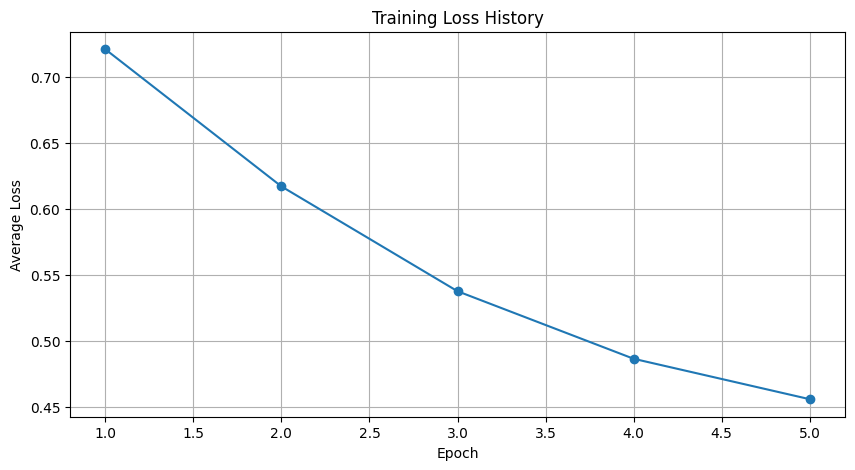

In [6]:
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.datasets import CocoDetection
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Subset
import random


def collate_fn(batch):
    return tuple(zip(*batch))


def prepare_target(target):

    boxes = []
    labels = []
    for annotation in target:
        boxes.append(annotation['bbox'])
        labels.append(annotation['category_id'])
    
    if len(boxes) == 0:
        # Return None if there are no annotations
        return None

    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.as_tensor(labels, dtype=torch.int64)
    
    # Convert [x, y, w, h] to [x1, y1, x2, y2]
    boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
    boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
    
    return {'boxes': boxes, 'labels': labels}

# Make sure to download COCO dataset (images, annotations) from https://cocodataset.org/#download 
# Set up the COCO dataset
train_dataset = CocoDetection(
    root='/train2017/train2017/',
    annFile='/annotations_trainval2017/annotations/instances_train2017.json',
    transform=ToTensor()
)

test_dataset = CocoDetection(
    root='/test2017/test2017/',
    annFile='/image_info_test2017/annotations/image_info_test2017.json',
    transform=ToTensor()
)

# Get the total number of samples in the dataset
total_samples_train = len(train_dataset)
total_samples_test = len(test_dataset)
print('total_samples_train: ', total_samples_train)
print('total_samples_test: ', total_samples_test)

# Generate 10,000 random indices
# subset_indices_train = random.sample(range(total_samples_train), 500)
# subset_indices_test = random.sample(range(total_samples_train), 500)
train_num_samp = 2000

# Create a subset of the dataset
subset_train_dataset = Subset(train_dataset, list(range(0, train_num_samp + 1)))
subset_test_dataset = Subset(train_dataset, list(range(train_num_samp + 10, (train_num_samp*2) + 1)))
print('subset_train_dataset: ', len(subset_train_dataset))
print('subset_test_dataset: ', len(subset_test_dataset))

# Now use this subset to create your DataLoader
train_loader = DataLoader(subset_train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(subset_test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
print('train_loader: ', len(train_loader))
print('test_loader: ', len(test_loader))

# Load a pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)

# # Assuming 'model' is your Faster R-CNN model
# if torch.cuda.device_count() > 1:
#     print(f"Using {torch.cuda.device_count()} GPUs!")
#     model = nn.DataParallel(model)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set up optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training loop
num_epochs = 5
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = [image.to(device) for image in images]
        prepared_targets = [prepare_target(t) for t in targets]
        
        # Filter out images without annotations
        valid_images = []
        valid_targets = []
        for img, tgt in zip(images, prepared_targets):
            if tgt is not None:
                valid_images.append(img)
                valid_targets.append({k: v.to(device) for k, v in tgt.items()})
        
        if len(valid_images) == 0:
            continue  # Skip this batch if no valid images

 
        loss_dict = model(valid_images, valid_targets)
        losses = sum(loss for loss in loss_dict.values())
        #print('losses:', losses.item())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        epoch_loss += losses.item()
    
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.title('Training Loss History')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.savefig('training_history.png')
plt.show()

# Save the trained model
torch.save(model.state_dict(), '/faster_rcnn_coco.pth')



In [7]:
# Test the model
model.eval()
test_losses = []

with torch.no_grad():
    for images, targets in tqdm(test_loader, desc="Testing"):
        images = [image.to(device) for image in images]
        prepared_targets = [prepare_target(t) for t in targets]
        # print(f"Length of images: {len(images)}")
        # print(f"Length of targets: {len(targets)}")

        valid_images = []
        valid_targets = []
        for img, tgt in zip(images, prepared_targets):
            #is not None
            if tgt:
                valid_images.append(img)
                valid_targets.append({k: v.to(device) for k, v in tgt.items()})
        
        if len(valid_images) == 0:
            continue  # Skip this batch if no valid images
        
        loss_dict = model(valid_images, valid_targets)
        #print(len(loss_dict), type(loss_dict), loss_dict[0])
        
        test_losses.append(losses.item())

avg_test_loss = sum(test_losses) / len(test_losses)
print(f"Average Test Loss: {avg_test_loss:.4f}")


Testing: 100%|██████████| 1991/1991 [03:13<00:00, 10.31it/s]

Average Test Loss: 0.1921


In [8]:
# # Visualize a sample prediction
model.eval()
image, target = next(iter(test_loader))
image, target = next(iter(test_loader))
image = image[0].to(device)
prediction = model([image])[0]
image = image[0].cpu()


# Get the COCO class names
coco_names = train_dataset.coco.loadCats(train_dataset.coco.getCatIds())
coco_names = [cat['name'] for cat in coco_names]


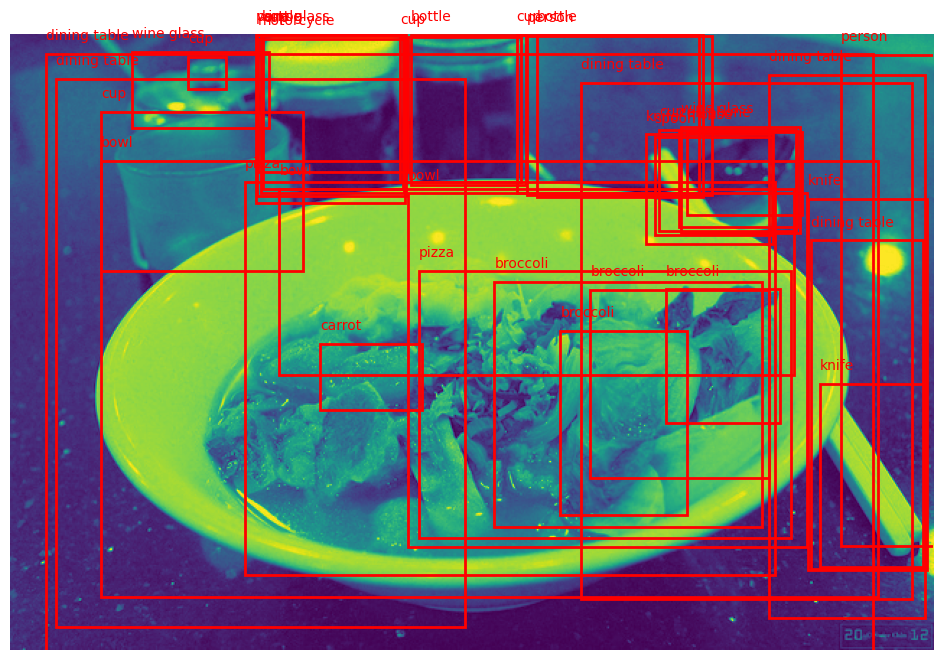

product attributes:  ['cup', 'bottle', 'broccoli', 'dining table', 'bowl', 'broccoli', 'bottle', 'cell phone', 'cup', 'pizza', 'cup', 'carrot', 'broccoli', 'person', 'dining table', 'spoon', 'person', 'bowl', 'cup', 'wine glass', 'bottle', 'knife', 'cup', 'knife', 'knife', 'cup', 'motorcycle', 'broccoli', 'person', 'dining table', 'dining table', 'dining table', 'mouse', 'bowl', 'wine glass', 'pizza', 'wine glass']


In [9]:
class_labels = []

plt.figure(figsize=(12, 8))
plt.imshow(image) 
for box, label in zip(prediction['boxes'], prediction['labels']):
    x1, y1, x2, y2 = box.detach().cpu().numpy()
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='r', linewidth=2))
    class_name = train_dataset.coco.loadCats(label.item())[0]['name']
    class_labels.append(class_name)
    plt.text(x1, y1-10, class_name, color='r', fontsize=10)
plt.axis('off')
plt.show()

print('product attributes: ', class_labels)


In [10]:
import pandas as pd
df_prodattrib = pd.DataFrame(class_labels, columns=['prod_attrib'])
df_prodattrib.head()
groups = df_prodattrib.groupby('prod_attrib')['prod_attrib'].count()
print(groups)

# This dataframe df_prodattrib can then be written to any database for downstream operations to build customer sales or engagement 
# related models, once customer interaction lifecycle data is attached to the image product attributes


prod_attrib
bottle          3
bowl            3
broccoli        4
carrot          1
cell phone      1
cup             6
dining table    5
knife           3
motorcycle      1
mouse           1
person          3
pizza           2
spoon           1
wine glass      3
Name: prod_attrib, dtype: int64
